# Import libraries and modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import re
import os
import tweepy
import time
import json
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
%matplotlib inline


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Data Gathering

### Retrieve file from Udacity server

In [2]:
# retrieve file from udacity server
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

In [3]:
# create file, write content, save file to notebook
with open (url.split('/')[-1], mode='wb')as file:
    file.write(r.content)

In [4]:
# create dataframe from file
df_dog_breed = pd.read_csv('image-predictions.tsv', sep='\t')

In [5]:
# inspect data
df_dog_breed.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### Load data from csv file provided in Jupiter Notebook

In [6]:
# create dataframe from file
df_twitter_csv = pd.read_csv('twitter-archive-enhanced.csv')

In [7]:
# inspect data
df_twitter_csv.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### Query Twitter API for more data

In [8]:
# create Series of tweet ids
id_of_tweet = df_twitter_csv.tweet_id

In [9]:
# inspect data
id_of_tweet.head()

0    892420643555336193
1    892177421306343426
2    891815181378084864
3    891689557279858688
4    891327558926688256
Name: tweet_id, dtype: int64

In [10]:
# inspect for duplicates
sum(id_of_tweet.duplicated())


0

In [13]:
# set up query for twitter api
consumer_key = 'A'
consumer_secret = 'B'
access_token = 'C'
access_secret = 'D'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth,wait_on_rate_limit=True, wait_on_rate_limit_notify=True )

In [ ]:
# query Twitter API and save to json file
count = 0
start = time.time()
twitter_list = []
failed_list = []
for tweet in id_of_tweet:
    try:
        info = api.get_status(tweet, tweet_mode='extended')
        twitter_list.append(info._json)
        print('{}. Passed : {}'.format(count, tweet))
    except:
        print('{}. Failed : {}'.format(count, tweet))
        failed_list.append(count)
    end = time.time()
    delta = end - start
    count += 1
    print('Elapsed time: {:2f}'.format(delta))

with open('tweet_json.txt', 'w') as outfile:
    json.dump(twitter_list, outfile)

0. Passed : 892420643555336193
Elapsed time: 0.183601
1. Passed : 892177421306343426
Elapsed time: 0.400490
2. Passed : 891815181378084864
Elapsed time: 0.569388
3. Passed : 891689557279858688
Elapsed time: 0.754909
4. Passed : 891327558926688256
Elapsed time: 0.934643
5. Passed : 891087950875897856
Elapsed time: 1.122034
6. Passed : 890971913173991426
Elapsed time: 1.291858
7. Passed : 890729181411237888
Elapsed time: 1.465765
8. Passed : 890609185150312448
Elapsed time: 1.647179
9. Passed : 890240255349198849
Elapsed time: 1.818713
10. Passed : 890006608113172480
Elapsed time: 1.993886
11. Passed : 889880896479866881
Elapsed time: 2.171718
12. Passed : 889665388333682689
Elapsed time: 2.354826
13. Passed : 889638837579907072
Elapsed time: 2.535007
14. Passed : 889531135344209921
Elapsed time: 2.706303
15. Passed : 889278841981685760
Elapsed time: 2.886761
16. Passed : 888917238123831296
Elapsed time: 3.070706
17. Passed : 888804989199671297
Elapsed time: 3.250903
18. Passed : 8885549

147. Passed : 863432100342583297
Elapsed time: 27.559551
148. Passed : 863427515083354112
Elapsed time: 27.738588
149. Passed : 863079547188785154
Elapsed time: 27.913506
150. Passed : 863062471531167744
Elapsed time: 28.091962
151. Passed : 862831371563274240
Elapsed time: 28.279840
152. Passed : 862722525377298433
Elapsed time: 28.464283
153. Passed : 862457590147678208
Elapsed time: 28.650337
154. Passed : 862096992088072192
Elapsed time: 28.828444
155. Failed : 861769973181624320
Elapsed time: 28.992031
156. Passed : 861383897657036800
Elapsed time: 29.173862
157. Passed : 861288531465048066
Elapsed time: 29.357975
158. Passed : 861005113778896900
Elapsed time: 29.551761
159. Passed : 860981674716409858
Elapsed time: 29.749352
160. Passed : 860924035999428608
Elapsed time: 29.953561
161. Passed : 860563773140209665
Elapsed time: 30.135348
162. Passed : 860524505164394496
Elapsed time: 30.303661
163. Passed : 860276583193509888
Elapsed time: 30.477329
164. Passed : 86018484939461017

292. Passed : 838083903487373313
Elapsed time: 54.455833
293. Passed : 837820167694528512
Elapsed time: 54.624740
294. Passed : 837482249356513284
Elapsed time: 54.798872
295. Passed : 837471256429613056
Elapsed time: 54.983908
296. Passed : 837366284874571778
Elapsed time: 55.161312
297. Passed : 837110210464448512
Elapsed time: 55.338107
298. Failed : 837012587749474308
Elapsed time: 55.509836
299. Passed : 836989968035819520
Elapsed time: 55.689074
300. Passed : 836753516572119041
Elapsed time: 55.852252
301. Passed : 836677758902222849
Elapsed time: 56.025408
302. Passed : 836648853927522308
Elapsed time: 56.248054
303. Passed : 836397794269200385
Elapsed time: 56.429771
304. Passed : 836380477523124226
Elapsed time: 56.601753
305. Passed : 836260088725786625
Elapsed time: 56.773658
306. Passed : 836001077879255040
Elapsed time: 56.959180
307. Passed : 835685285446955009
Elapsed time: 57.135801
308. Passed : 835574547218894849
Elapsed time: 57.302366
309. Passed : 83553646897830297

436. Passed : 820314633777061888
Elapsed time: 81.520849
437. Passed : 820078625395449857
Elapsed time: 81.693387
438. Passed : 820013781606658049
Elapsed time: 81.883351
439. Passed : 819952236453363712
Elapsed time: 82.066565
440. Passed : 819924195358416896
Elapsed time: 82.235962
441. Passed : 819711362133872643
Elapsed time: 82.404737
442. Passed : 819588359383371776
Elapsed time: 82.578293
443. Passed : 819347104292290561
Elapsed time: 82.777554
444. Passed : 819238181065359361
Elapsed time: 82.952562
445. Passed : 819227688460238848
Elapsed time: 83.127849
446. Passed : 819015337530290176
Elapsed time: 83.322656
447. Passed : 819015331746349057
Elapsed time: 83.514051
448. Passed : 819006400881917954
Elapsed time: 83.683563
449. Passed : 819004803107983360
Elapsed time: 83.858848
450. Passed : 818646164899774465
Elapsed time: 84.033541
451. Passed : 818627210458333184
Elapsed time: 84.212577
452. Passed : 818614493328580609
Elapsed time: 84.387249
453. Passed : 81858883507660390

581. Passed : 800443802682937345
Elapsed time: 108.025655
582. Passed : 800388270626521089
Elapsed time: 108.204666
583. Passed : 800188575492947969
Elapsed time: 108.386035
584. Passed : 800141422401830912
Elapsed time: 108.572220
585. Passed : 800018252395122689
Elapsed time: 108.752193
586. Passed : 799774291445383169
Elapsed time: 108.926408
587. Passed : 799757965289017345
Elapsed time: 109.099610
588. Passed : 799422933579902976
Elapsed time: 109.268964
589. Passed : 799308762079035393
Elapsed time: 109.448419
590. Passed : 799297110730567681
Elapsed time: 109.616772
591. Passed : 799063482566066176
Elapsed time: 109.785296
592. Passed : 798933969379225600
Elapsed time: 109.960551
593. Passed : 798925684722855936
Elapsed time: 110.139272
594. Passed : 798705661114773508
Elapsed time: 110.342717
595. Passed : 798701998996647937
Elapsed time: 110.533658
596. Passed : 798697898615730177
Elapsed time: 110.707163
597. Passed : 798694562394996736
Elapsed time: 110.916290
598. Passed : 

723. Passed : 782969140009107456
Elapsed time: 134.621724
724. Passed : 782747134529531904
Elapsed time: 134.846765
725. Passed : 782722598790725632
Elapsed time: 135.022403
726. Passed : 782598640137187329
Elapsed time: 135.197383
727. Passed : 782305867769217024
Elapsed time: 135.374102
728. Passed : 782021823840026624
Elapsed time: 135.554180
729. Passed : 781955203444699136
Elapsed time: 135.730941
730. Passed : 781661882474196992
Elapsed time: 135.918938
731. Passed : 781655249211752448
Elapsed time: 136.111102
732. Passed : 781524693396357120
Elapsed time: 136.278991
733. Passed : 781308096455073793
Elapsed time: 136.477641
734. Passed : 781251288990355457
Elapsed time: 136.658681
735. Passed : 781163403222056960
Elapsed time: 136.829819
736. Passed : 780931614150983680
Elapsed time: 137.013313
737. Passed : 780858289093574656
Elapsed time: 137.217366
738. Passed : 780800785462489090
Elapsed time: 137.387683
739. Passed : 780601303617732608
Elapsed time: 137.633842
740. Passed : 

865. Passed : 762316489655476224
Elapsed time: 161.101290
866. Passed : 762035686371364864
Elapsed time: 161.280083
867. Passed : 761976711479193600
Elapsed time: 161.457814
868. Passed : 761750502866649088
Elapsed time: 161.646638
869. Passed : 761745352076779520
Elapsed time: 161.834280
870. Passed : 761672994376806400
Elapsed time: 162.009407
871. Passed : 761599872357261312
Elapsed time: 162.181653
872. Passed : 761371037149827077
Elapsed time: 162.393695
873. Passed : 761334018830917632
Elapsed time: 162.575992
874. Passed : 761292947749015552
Elapsed time: 162.746598
875. Passed : 761227390836215808
Elapsed time: 162.924267
876. Passed : 761004547850530816
Elapsed time: 163.098914
877. Passed : 760893934457552897
Elapsed time: 163.305627
878. Passed : 760656994973933572
Elapsed time: 163.481766
879. Passed : 760641137271070720
Elapsed time: 163.673441
880. Passed : 760539183865880579
Elapsed time: 163.850159
881. Passed : 760521673607086080
Elapsed time: 164.021423
882. Passed : 

1008. Passed : 747594051852075008
Elapsed time: 187.509304
1009. Passed : 747512671126323200
Elapsed time: 187.686048
1010. Passed : 747461612269887489
Elapsed time: 187.866188
1011. Passed : 747439450712596480
Elapsed time: 188.053110
1012. Passed : 747242308580548608
Elapsed time: 188.267015
1013. Passed : 747219827526344708
Elapsed time: 188.582128
1014. Passed : 747204161125646336
Elapsed time: 188.766261
1015. Passed : 747103485104099331
Elapsed time: 189.007212
1016. Passed : 746906459439529985
Elapsed time: 189.187756
1017. Passed : 746872823977771008
Elapsed time: 189.372470
1018. Passed : 746818907684614144
Elapsed time: 189.550113
1019. Passed : 746790600704425984
Elapsed time: 189.730502
1020. Passed : 746757706116112384
Elapsed time: 189.920791
1021. Passed : 746726898085036033
Elapsed time: 190.124344
1022. Passed : 746542875601690625
Elapsed time: 190.304660
1023. Passed : 746521445350707200
Elapsed time: 190.497648
1024. Passed : 746507379341139972
Elapsed time: 190.6951

1148. Passed : 726887082820554753
Elapsed time: 213.695184
1149. Passed : 726828223124897792
Elapsed time: 213.874955
1150. Passed : 726224900189511680
Elapsed time: 214.051955
1151. Passed : 725842289046749185
Elapsed time: 214.281342
1152. Passed : 725786712245440512
Elapsed time: 214.468934
1153. Passed : 725729321944506368
Elapsed time: 214.644011
1154. Passed : 725458796924002305
Elapsed time: 214.837965
1155. Passed : 724983749226668032
Elapsed time: 215.014937
1156. Passed : 724771698126512129
Elapsed time: 215.197506
1157. Passed : 724405726123311104
Elapsed time: 215.379858
1158. Passed : 724049859469295616
Elapsed time: 215.575454
1159. Passed : 724046343203856385
Elapsed time: 215.761224
1160. Passed : 724004602748780546
Elapsed time: 215.954377
1161. Passed : 723912936180330496
Elapsed time: 216.136105
1162. Passed : 723688335806480385
Elapsed time: 216.350308
1163. Passed : 723673163800948736
Elapsed time: 216.533454
1164. Passed : 723179728551723008
Elapsed time: 216.7252

In [58]:
print(failed_list)

[19, 95, 101, 104, 118, 132, 155, 182, 247, 253, 260, 298, 382, 506, 566, 784, 818, 932, 1726]


In [11]:
# save failed list
failed_list = [19, 95, 101, 104, 118, 132, 155, 182, 247, 253, 260, 298, 382, 506, 566, 784, 818, 932, 1726]

In [12]:
# number of failed retrievals
len(failed_list)

19

In [13]:
# load json data from file
with open ('tweet_json.txt', 'r') as file:
    data = json.load(file)


In [14]:
# inspect data
len(data)

2337

In [15]:
# inspect data
data[0].keys()

dict_keys(['created_at', 'id', 'id_str', 'full_text', 'truncated', 'display_text_range', 'entities', 'extended_entities', 'source', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place', 'contributors', 'is_quote_status', 'retweet_count', 'favorite_count', 'favorited', 'retweeted', 'possibly_sensitive', 'possibly_sensitive_appealable', 'lang'])

In [16]:
# create data frame with selected columns
choice = ['id','created_at', 'retweet_count', 'favorite_count', 'user', 'quoted_status', 'retweeted_status']
df_twitter_api = pd.DataFrame(data, columns=choice)

In [17]:
# inspect data
df_twitter_api.head()

,id,created_at,retweet_count,favorite_count,user,quoted_status,retweeted_status
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8199,37609,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6065,32320,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4011,24350,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8362,40934,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9052,39144,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN


# Goal of analysis

**I will try to answer the following questions I am interested in:**

-  Which dog breed gets the highest ratings?
-  Which dog breed gets the highest favorite count?
-  Which dog stage gets the highest ratings?
-  Which dog stage gets the highest favorite count?
-  Is a prediction of the year of a tweet possible?
-  Are higher ratings associated with certain dog names??
-  What is the distribution of original tweets for certain weekdays?
-  Are retweet and favorite counts correlated?


# Data assessment

### Visual assessment

In [18]:
# display data frame retrieved from Udacity
df_dog_breed

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [19]:
# display data frame provided as csv file
df_twitter_csv

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [20]:
# display data frame retrieved from twitter api
df_twitter_api

,id,created_at,retweet_count,favorite_count,user,quoted_status,retweeted_status
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8199,37609,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6065,32320,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4011,24350,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8362,40934,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9052,39144,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
5,891087950875897856,Sat Jul 29 00:08:17 +0000 2017,3006,19679,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
6,890971913173991426,Fri Jul 28 16:27:12 +0000 2017,1986,11508,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
7,890729181411237888,Fri Jul 28 00:22:40 +0000 2017,18219,63440,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
8,890609185150312448,Thu Jul 27 16:25:51 +0000 2017,4124,27067,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN
9,890240255349198849,Wed Jul 26 15:59:51 +0000 2017,7122,31013,"{'id': 4196983835, 'id_str': '4196983835', 'na...",NaN,NaN


#### Findings

**Quality:**

- dog_breed table: dog names lower and upper case, words are divided by _ or -
- twitter_csv table: name: missing names and wrong names
- twitter_csv table: reextract doggo, floofer, puppo, pupper
- twitter_csv table: delete retweets
- twitter_csv: delete tweets newer than August 1st 2017 (no dog breed entries beyond that point)
- twitter_api table: delete retweets and quoted tweets

#### Findings

**Tidiness:**

- dog_breed table: jpg_url, img_num not needed
- dog_breed table: condense dog breed predictions into one column
- twitter_csv table: merge stage columns into one column
- twitter_csv table: in_reply_to_status_id, in_reply_to_user_id not needed
- twitter_csv table: source: more information than the url(additional format characters)
- twitter_api table: user: > 1 entries in columns
- merge tables to master table for analysis



## Programmatic assessment

In [21]:
# display data frame and column parameters for missing data and dtypes
df_dog_breed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
# display data frame and column parameters for missing data and dtypes
df_twitter_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [23]:
# inspect name column for quality issues
df_twitter_csv['name'].value_counts()

None          745
a              55
Charlie        12
Lucy           11
Oliver         11
Cooper         11
Penny          10
Tucker         10
Lola           10
Winston         9
Bo              9
Sadie           8
the             8
Bailey          7
Buddy           7
Daisy           7
an              7
Toby            7
Stanley         6
Bella           6
Jack            6
Jax             6
Leo             6
Scout           6
Koda            6
Rusty           6
Dave            6
Oscar           6
Milo            6
Chester         5
             ... 
Todo            1
Antony          1
incredibly      1
Hubertson       1
Toffee          1
Dewey           1
this            1
Siba            1
Cal             1
Stefan          1
Gerbald         1
Brady           1
Burt            1
Ron             1
Rontu           1
Snickers        1
Lipton          1
Grizzwald       1
Kuyu            1
Kendall         1
Monster         1
Andy            1
Zeus            1
Bert            1
Sully     

In [24]:
# inspect rating_numerator column for quality issues
df_twitter_csv['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [25]:
# inspect rating_denominator column for quality issues
df_twitter_csv['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [26]:
# inspect if high denominator is always a false entry
df_twitter_csv[df_twitter_csv['rating_denominator'] == 40]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1433,697463031882764288,NaN,NaN,2016-02-10 16:51:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy Wednesday here's a bucket of pups. 44/40...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697463031...,44,40,None,None,None,None,None


In [27]:
# inspect if high denominator is always a false entry
df_twitter_csv['text'][1433]

"Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ"

In [28]:
# inspect stages columns for quality issues
df_twitter_csv['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [29]:
# inspect stages columns for quality issues
df_twitter_csv['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [30]:
# inspect stages columns for quality issues
df_twitter_csv['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [31]:
# inspect stages columns for quality issues
df_twitter_csv['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [32]:
# display data frame and column parameters for missing data and dtypes
df_twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 7 columns):
id                  2337 non-null int64
created_at          2337 non-null object
retweet_count       2337 non-null int64
favorite_count      2337 non-null int64
user                2337 non-null object
quoted_status       24 non-null object
retweeted_status    166 non-null object
dtypes: int64(3), object(4)
memory usage: 127.9+ KB


#### Findings

**Quality:**

- different number of datapoints between tables, keep in mind for merging
- twitter_csv table: timestamp: string object
- twitter_csv table: rating_numerator has to be reextracted
- twitter_csv table: rating denominator has to be set to 10
- twitter_api table: created_at: string instead of datetime


## Summary data assessment

**Quality issues:**


Q1) dog_breed table: dog breed names lower and upper case, words are divided by _ or -

Q2) twitter_csv table: name: missing names and wrong names

Q3) twitter_csv table: change dtype of retweet columns and delete retweets

Q4) twitter_csv: delete tweets newer than August 1st 2017 (no dog breed entries beyond that point)

Q5) twitter_csv table: timestamp: string object

Q6) twitter_csv table: rating_numerator has to be reextracted

Q7) twitter_csv table: rating denominator has to be set to 10

Q8) twitter_api table: created_at: string instead of datetime

Q9) twitter_api table: change dtype of retweed_status and quoted_status columns and delete retweets and quoted tweets 

Q10) twitter_api table: delete tweets newer than August 1st 2017 (no dog breed entries beyond that point)

Q11) twitter_archive master: add additional columns after EDA if necessary



**Tidiness issues:**

T1) dog_breed table: jpg_url, img_num not needed

T2) dog_breed table: condense dog breed predictions into one column

T3) twitter_csv table: merge stage columns into one column

T4) twitter_csv table: in_reply_to_status_id, in_reply_to_user_id not needed

T5) twitter_csv table: source: more information than the url(additional format characters)

T6) twitter_api table: user: > 1 entries in column

T7) merge tables to master table for analysis, different number of datapoints between tables, keep in mind for merging

# Data cleaning

In [33]:
# make copies of data frames
df_dog_breed_clean = df_dog_breed.copy()
df_twitter_csv_clean = df_twitter_csv.copy()
df_twitter_api_clean = df_twitter_api.copy()

**T1) dog_breed table: jpg_url, img_num not needed**

**Define**

**Delete columns jpg_url and img_num**

**Clean**

In [34]:
# delete columns
df_dog_breed_clean.drop(['jpg_url', 'img_num'], axis=1, inplace=True)

**Test**

In [35]:
# inspect data
df_dog_breed_clean.head()

,tweet_id,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**T2) dog_breed table: condense dog breed predictions into one column**

**Define**

**Create a column with predicted dog breeds if p1_dog or p2_dog or p3_dog are True (i.e. a dog was recognized by the algorithm either in the first, second or third place). If all 3 are false nevertheless keep the rows with 'udo' (unidentified dog objects) because despite the algorithm did not recognize a dog udos also maybe good dogs Brent.** 

**Clean**

In [36]:
# write function for condensing dog breed predictions into one column
p1_new = []

def getdogs(df):
    for i in range(len(df)):
        if df.loc[i, 'p1_dog']:
            p1_new.append(df.loc[i, 'p1'])
        elif df.loc[i, 'p2_dog']:
            p1_new.append(df.loc[i, 'p2'])
        elif df.loc[i, 'p3_dog']:
            p1_new.append(df.loc[i, 'p3'])
        else:
            p1_new.append('udo')

In [37]:
# apply function
getdogs(df_dog_breed_clean)

In [38]:
# inspect data
len(p1_new)

2075

In [39]:
# add new column to data frame
df_dog_breed_clean['p1_new'] = pd.Series(p1_new)

In [40]:
# delete not needed old columns
df_dog_breed_clean.drop([ 'p1','p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis=1, inplace=True)

**Test**

In [41]:
# inspect data
df_dog_breed_clean.head(15)

,tweet_id,p1_new
0,666020888022790149,Welsh_springer_spaniel
1,666029285002620928,redbone
2,666033412701032449,German_shepherd
3,666044226329800704,Rhodesian_ridgeback
4,666049248165822465,miniature_pinscher
5,666050758794694657,Bernese_mountain_dog
6,666051853826850816,udo
7,666055525042405380,chow
8,666057090499244032,golden_retriever
9,666058600524156928,miniature_poodle


**Q1) dog_breed table: dog breed names lower and upper case, words are divided by _ or -**

**Define**

**Replace name seperators and write names in lowercase**

**Clean**

In [42]:
# clean new dog breeds column
df_dog_breed_clean['p1_new'] = df_dog_breed_clean.p1_new.apply(lambda x: x.lower().replace('_', ' ').replace('-', ' '))

**Test**

In [43]:
# inspect data
df_dog_breed_clean

,tweet_id,p1_new
0,666020888022790149,welsh springer spaniel
1,666029285002620928,redbone
2,666033412701032449,german shepherd
3,666044226329800704,rhodesian ridgeback
4,666049248165822465,miniature pinscher
5,666050758794694657,bernese mountain dog
6,666051853826850816,udo
7,666055525042405380,chow
8,666057090499244032,golden retriever
9,666058600524156928,miniature poodle


**Q2) twitter_csv table: name: missing names and wrong names**

**Define**

**Analyze structure of text column and reextract names. If there are 2 dogs on a photo just extract one name.**

In [44]:
# analyze structure of text column
df_twitter_csv_clean['text'].sample(50)

1800    This is Cooper. He doesn't know how cheese wor...
2253    Dogs only please. Small cows and other non can...
2191    This is a Slovakian Helter Skelter Feta named ...
570     .@NBCSports OMG THE TINY HAT I'M GOING TO HAVE...
1646    Here we see a faulty pupper. Might need to rep...
867     This is Shelby. She finds stuff to put on her ...
205     Meet Benny. He likes being adorable and making...
1913    Meet Chesney. On the outside he stays calm &am...
1084    "Don't talk to me or my son ever again" ...10/...
929     This is Milo. He's currently plotting his reve...
301     Say hello to Oliver. He's pretty exotic. Fairl...
1302    This is Harper. She scraped her elbow attempti...
625     This is Brody. He's trying to make the same fa...
1043    RT @dog_rates: Extremely intelligent dog here....
1585    This is Jackson. He was specifically told not ...
2305    My goodness. Very rare dog here. Large. Tail d...
1026    This is Gustav. He has claimed that plant. It ...
41      I pres

In [45]:
# analyze structure of text column
df_twitter_csv_clean[df_twitter_csv['text'].str.contains('named')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
603,798628517273620480,NaN,NaN,2016-11-15 20:47:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This a Norwegian Pewterschmidt ...,6.675094e+17,4.196984e+09,2015-11-20 01:06:48 +0000,https://twitter.com/dog_rates/status/667509364...,12,10,None,None,None,None,None
1853,675706639471788032,NaN,NaN,2015-12-12 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Sizzlin Menorah spaniel from Brookly...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/675706639...,10,10,a,None,None,None,None
1955,673636718965334016,NaN,NaN,2015-12-06 22:54:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Lofted Aphrodisiac Terrier named Kip...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673636718...,10,10,a,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,a,None,None,None,None
2066,671147085991960577,NaN,NaN,2015-11-30 02:01:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Helvetica Listerine named Rufus. Thi...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671147085...,9,10,a,None,None,None,None
2116,670427002554466305,NaN,NaN,2015-11-28 02:20:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Deciduous Trimester mix named Spork....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670427002...,9,10,a,None,None,None,None
2125,670361874861563904,NaN,NaN,2015-11-27 22:01:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Rich Mahogany Seltzer named Cherokee...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670361874...,9,10,a,None,None,None,None
2128,670303360680108032,NaN,NaN,2015-11-27 18:09:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Speckled Cauliflower Yosemite named ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670303360...,9,10,a,None,None,None,None
2146,669923323644657664,NaN,NaN,2015-11-26 16:59:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a spotted Lipitor Rumpelstiltskin name...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669923323...,10,10,a,None,None,None,None
2161,669564461267722241,NaN,NaN,2015-11-25 17:13:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Coriander Baton Rouge named Alfredo....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/669564461...,10,10,a,None,None,None,None


In [46]:
# analyze structure of text column
df_twitter_csv_clean['text'][2311]

'This is a purebred Bacardi named Octaviath. Can shoot spaghetti out of mouth. 10/10 https://t.co/uEvsGLOFHa'

In [47]:
# analyze structure of text column
df_twitter_csv_clean[df_twitter_csv_clean['text'].str.contains('Meet')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
57,881268444196462592,NaN,NaN,2017-07-01 21:49:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Elliot. He's a Canadian Forrest Pup. Unus...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881268444...,12,10,Elliot,None,None,None,None
61,880221127280381952,NaN,NaN,2017-06-29 00:27:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jesse. He's a Fetty Woof. His tongue ejec...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/880221127...,12,10,Jesse,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
75,878281511006478336,NaN,NaN,2017-06-23 16:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Shadow. In an attempt to reach maximum zo...,NaN,NaN,NaN,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
80,877316821321428993,NaN,NaN,2017-06-21 00:06:44 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Dante. At first he wasn't a fan of his ne...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/877316821...,13,10,Dante,None,None,None,None
85,876120275196170240,NaN,NaN,2017-06-17 16:52:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Meet Venti, a seemingly caffeinated puppoccino...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/876120275...,13,10,Venti,None,None,None,None


In [48]:
# analyze structure of text column
df_twitter_csv_clean['text'][128]

"Meet Harold.  He's h*ckin cooperative. 13/10 good work Harold https://t.co/ZYg3NZGICa"

In [49]:
# prepare text column for name extraction
df_twitter_csv_clean['text_1'] = df_twitter_csv_clean['text'].apply(lambda x: x.split('.')[0])

In [50]:
# prepare text column for name extraction
df_twitter_csv_clean['text_1'] = df_twitter_csv_clean['text_1'].str.split()

In [51]:
# inspect data
df_twitter_csv_clean['text_1'][748]

['Have',
 'you',
 'ever',
 'seen',
 'such',
 'a',
 'smol',
 'pupper?',
 'Portable',
 'af']

In [52]:
# write function for extracting names
names = []
def getnames(row):
    if 'named' in row['text_1'] and re.match((r'[A-Z][a-z].*'), row['text_1'][(row['text_1'].index('named')+1)]):
        names.append(row['text_1'][(row['text_1'].index('named')+1)])
    elif len(row['text_1']) > 3 and row['text_1'][0] == 'Here' and re.match((r'[A-Z][a-z].*'), row['text_1'][(row['text_1'].index('Here')+3)]):
        try:
            names.append(row['text_1'][(row['text_1'].index('Here')+3)].strip(' ,'))
        except:
            names.append(np.nan)
    elif len(row['text_1']) > 2 and row['text_1'][0] == 'This' and re.match((r'[A-Z][a-z].*'), row['text_1'][(row['text_1'].index('This')+2)]):
        try:
            names.append(row['text_1'][(row['text_1'].index('This')+2)].strip(' ,')) 
        except:
            names.append(np.nan)
    elif len(row['text_1']) > 3 and row['text_1'][0] == 'Say' and re.match((r'[A-Z][a-z].*'), row['text_1'][(row['text_1'].index('Say')+3)]):
        try:
            names.append(row['text_1'][(row['text_1'].index('Say')+3)].strip(' ,'))
        except:
            names.append(np.nan)
    elif len(row['text_1']) > 1 and row['text_1'][0] == 'Meet' and re.match((r'[A-Z][a-z].*'), row['text_1'][(row['text_1'].index('Meet')+1)]):
        try:
            names.append(row['text_1'][(row['text_1'].index('Meet')+1)].strip(' ,'))
        except:
            names.append(np.nan)
    else:
        names.append(np.nan)
        
        
        

In [53]:
# apply function to dataframe
df_twitter_csv_clean.apply(getnames, axis=1)

0       None
1       None
2       None
3       None
4       None
5       None
6       None
7       None
8       None
9       None
10      None
11      None
12      None
13      None
14      None
15      None
16      None
17      None
18      None
19      None
20      None
21      None
22      None
23      None
24      None
25      None
26      None
27      None
28      None
29      None
        ... 
2326    None
2327    None
2328    None
2329    None
2330    None
2331    None
2332    None
2333    None
2334    None
2335    None
2336    None
2337    None
2338    None
2339    None
2340    None
2341    None
2342    None
2343    None
2344    None
2345    None
2346    None
2347    None
2348    None
2349    None
2350    None
2351    None
2352    None
2353    None
2354    None
2355    None
Length: 2356, dtype: object

In [54]:
# inspect data
len(names)

2356

In [55]:
# add new column with extracted names
df_twitter_csv_clean['names_new'] = pd.Series(names)

In [56]:
# inspect for missing names
sum(df_twitter_csv_clean['names_new'].isnull())

944

In [57]:
# replace null values with string
df_twitter_csv_clean['names_new'].fillna('Not a name', inplace=True)

**Test**

In [58]:
# inspect data
df_twitter_csv_clean['names_new'].value_counts()

Not a name    944
Charlie        11
Lucy           11
Cooper         10
Oliver         10
Penny           9
Tucker          9
Sadie           8
Lola            8
Winston         8
Daisy           7
Stanley         6
Jax             6
Oscar           6
Bailey          6
Toby            6
Bella           6
Bo              6
Koda            6
Leo             5
Chester         5
Buddy           5
Milo            5
Rusty           5
Scout           5
Bentley         5
Louis           5
Finn            4
Maggie          4
Oakley          4
             ... 
Hermione        1
Shikha          1
Travis          1
Ziva            1
Zuzu            1
Tango           1
Ralphé          1
Sully           1
Angel           1
Tuco            1
Kirk            1
Stu             1
Stefan          1
Gerbald         1
Brady           1
Burt            1
Atlas           1
Meatball        1
Rontu           1
Snickers        1
Ken             1
Cali            1
Lipton          1
Grizzwald       1
Cal       

**Clean**

In [59]:
# delete not needed old name column
df_twitter_csv_clean.drop('name', axis=1, inplace=True)

**Test**

In [60]:
sum(df_twitter_csv_clean['names_new'].str.contains(','))

0

In [61]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,text_1,names_new
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,"[This, is, Phineas]",Phineas
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,None,None,None,None,"[This, is, Tilly]",Tilly
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,None,None,None,None,"[This, is, Archie]",Archie
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,None,None,None,None,"[This, is, Darla]",Darla
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,None,None,None,None,"[This, is, Franklin]",Franklin


**T3) twitter_csv table: merge stage columns into one column**

**Define**

**Explore if there are more dog stages to be found in the text than already existent in the data frame. If yes extract names into one new column. usd stands for unstaged dog. Delete old columns afterwards**

In [62]:
# test number of stages example dogg which gives more values than doggo
len(df_twitter_csv_clean[df_twitter_csv_clean['text'].str.contains('dogg')])

105

**Clean**

In [63]:
# list comprehension for merging stage column into one column
df_twitter_csv_clean['stages_new_1'] = ['doggo' if 'dogg' in text
                                       else 'floofer' if 'floof' in text
                                       else 'pupper' if 'pupper' in text
                                       else 'puppo' if 'puppo' in text 
                                       else 'usd' for text in df_twitter_csv_clean['text'].str.lower()]

**Test**

In [64]:
# inspect data
df_twitter_csv_clean['stages_new_1'].head(20)

0       usd
1       usd
2       usd
3       usd
4       usd
5       usd
6       usd
7       usd
8       usd
9     doggo
10      usd
11      usd
12    puppo
13      usd
14    puppo
15      usd
16      usd
17      usd
18      usd
19      usd
Name: stages_new_1, dtype: object

In [65]:
# inspect data
df_twitter_csv_clean.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,doggo,floofer,pupper,puppo,text_1,names_new,stages_new_1
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,None,None,None,None,"[This, is, Phineas]",Phineas,usd


**Clean**

In [66]:
# assign dtype category to stage column
df_twitter_csv_clean['stages_new_1'] = df_twitter_csv_clean['stages_new_1'].astype('category')

In [67]:
# delete old stage columns
df_twitter_csv_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True)

**Test**

In [68]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,text_1,names_new,stages_new_1
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,"[This, is, Phineas]",Phineas,usd
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,"[This, is, Tilly]",Tilly,usd
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,"[This, is, Archie]",Archie,usd
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,"[This, is, Darla]",Darla,usd
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,"[This, is, Franklin]",Franklin,usd


**T4) twitter_csv table: in_reply_to_status_id, in_reply_to_user_id not needed**

**Define**

**Delete columns from table**

**Clean**

In [69]:
# delete not needed columns
df_twitter_csv_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)

**Test**

In [70]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,text_1,names_new,stages_new_1
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,"[This, is, Phineas]",Phineas,usd
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,"[This, is, Tilly]",Tilly,usd
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,"[This, is, Archie]",Archie,usd
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,"[This, is, Darla]",Darla,usd
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,"[This, is, Franklin]",Franklin,usd


**T5) twitter_csv table: source: more information than the url(additional format characters)**

**Define**

**Split text and extract url in new column. Delete old column**

**Clean**

In [71]:
# add new column with extracted urls
df_twitter_csv_clean['source1'] = df_twitter_csv_clean['source'].apply(lambda x: x.split('"')[1])   

**Test**

In [72]:
# inspect data
df_twitter_csv_clean['source1'].value_counts()

http://twitter.com/download/iphone              2221
http://vine.co                                    91
http://twitter.com                                33
https://about.twitter.com/products/tweetdeck      11
Name: source1, dtype: int64

**Clean**

In [73]:
# delete old column
df_twitter_csv_clean.drop('source', axis=1, inplace=True)

**Test**

In [74]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,timestamp,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,text_1,names_new,stages_new_1,source1
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,"[This, is, Phineas]",Phineas,usd,http://twitter.com/download/iphone
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,"[This, is, Tilly]",Tilly,usd,http://twitter.com/download/iphone
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,"[This, is, Archie]",Archie,usd,http://twitter.com/download/iphone
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,"[This, is, Darla]",Darla,usd,http://twitter.com/download/iphone
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,"[This, is, Franklin]",Franklin,usd,http://twitter.com/download/iphone


**Q3) twitter_csv table: change dtype of retweet columns and delete retweets**

**Define**

**Delete retweets and delete column for retweets afterwards**

**Clean**

In [75]:
# change dtype of retweeted columns
df_twitter_csv_clean['retweeted_status_id'] = df_twitter_csv_clean['retweeted_status_id'].apply(str)

In [76]:
# change dtype of retweeted columns
df_twitter_csv_clean['retweeted_status_user_id'] = df_twitter_csv_clean['retweeted_status_user_id'].apply(str)

In [77]:
# change dtype of retweeted columns
df_twitter_csv_clean['retweeted_status_timestamp'] = df_twitter_csv_clean['retweeted_status_timestamp'].apply(str)

**Test**

In [78]:
# inspect data
df_twitter_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 13 columns):
tweet_id                      2356 non-null int64
timestamp                     2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null object
retweeted_status_user_id      2356 non-null object
retweeted_status_timestamp    2356 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
text_1                        2356 non-null object
names_new                     2356 non-null object
stages_new_1                  2356 non-null category
source1                       2356 non-null object
dtypes: category(1), int64(3), object(9)
memory usage: 223.4+ KB


**Clean**

In [79]:
# extract original tweets without retweets
df_twitter_csv_clean = df_twitter_csv_clean[df_twitter_csv_clean['retweeted_status_id'] == 'nan']   

**Test**

In [80]:
# test for shorter dataframe
len(df_twitter_csv_clean)

2175

In [81]:
# test for retweets
assert len(df_twitter_csv_clean[df_twitter_csv_clean['retweeted_status_id'] != 'nan']) == 0   

In [82]:
# test for retweets
assert len(df_twitter_csv_clean[df_twitter_csv_clean['retweeted_status_user_id'] != 'nan']) == 0  

In [83]:
# test for retweets
assert len(df_twitter_csv_clean[df_twitter_csv_clean['retweeted_status_timestamp'] != 'nan']) == 0  

**Clean**

In [84]:
# delete retweeted columns 
df_twitter_csv_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)


**Test**

In [85]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,text_1,names_new,stages_new_1,source1
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,"[This, is, Phineas]",Phineas,usd,http://twitter.com/download/iphone
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,"[This, is, Tilly]",Tilly,usd,http://twitter.com/download/iphone
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,"[This, is, Archie]",Archie,usd,http://twitter.com/download/iphone
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,"[This, is, Darla]",Darla,usd,http://twitter.com/download/iphone
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,"[This, is, Franklin]",Franklin,usd,http://twitter.com/download/iphone


**Q5) twitter_csv table: timestamp: string object**

**Define**

**Convert timestamp into datetime column**

**Clean**

In [86]:
# create datetime column
df_twitter_csv_clean['Timestamp'] = pd.to_datetime(df_twitter_csv_clean['timestamp'])



**Test**

In [87]:
# inspect data
df_twitter_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null int64
timestamp             2175 non-null object
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
text_1                2175 non-null object
names_new             2175 non-null object
stages_new_1          2175 non-null category
source1               2175 non-null object
Timestamp             2175 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(3), object(6)
memory usage: 189.2+ KB


**Clean**

In [88]:
# delete timestamp column dtype str
df_twitter_csv_clean.drop('timestamp', axis=1, inplace=True)

**Test**

In [89]:
# inspect data
df_twitter_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 10 columns):
tweet_id              2175 non-null int64
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
text_1                2175 non-null object
names_new             2175 non-null object
stages_new_1          2175 non-null category
source1               2175 non-null object
Timestamp             2175 non-null datetime64[ns]
dtypes: category(1), datetime64[ns](1), int64(3), object(5)
memory usage: 172.2+ KB


**Q4) twitter_csv: delete tweets newer than August 1st 2017 (no dog breed entries beyond that point)**

**Define**

**Display start and end date and delete tweets 2017-08-02 and newer**

**Clean**

In [90]:
# display start and end dates of time series
df_twitter_csv_clean['Timestamp'].min(), df_twitter_csv_clean['Timestamp'].max()

(Timestamp('2015-11-15 22:32:08'), Timestamp('2017-08-01 16:23:56'))

**No cleaning and testing necessary as there are no tweets newer than 2017-08-01**

**Q6) twitter_csv table: rating_numerator has to be reextracted**

**Define**

**Reextract numerators and display examples > 14 and decide what to do with these entries (delete, set to 14..). I decided to delete all numbers < 15 as these are not too many and although there are some that seem to be multiple ratings - seen in combination with denominator - and could be recalculated there are too few to add substantial value.**

**Clean**

In [91]:
# analyze text column
df_twitter_csv_clean['text'][500]

"Meet Toby. He's pupset because his hat isn't big enough. Christmas is ruined. 12/10 it'll be ok Toby https://t.co/zfdaGZlweq"

In [92]:
# extract rating numerator into new column
df_twitter_csv_clean['rating_numerator_1'] = df_twitter_csv_clean['text'].str.extract(r'(\d?\d?\d?\d)/\d+')

**Test**

In [93]:
# inspect data
df_twitter_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
tweet_id              2175 non-null int64
text                  2175 non-null object
expanded_urls         2117 non-null object
rating_numerator      2175 non-null int64
rating_denominator    2175 non-null int64
text_1                2175 non-null object
names_new             2175 non-null object
stages_new_1          2175 non-null category
source1               2175 non-null object
Timestamp             2175 non-null datetime64[ns]
rating_numerator_1    2175 non-null object
dtypes: category(1), datetime64[ns](1), int64(3), object(6)
memory usage: 269.2+ KB


In [94]:
# inspect data
df_twitter_csv_clean['rating_numerator_1'].value_counts()

12      500
10      442
11      426
13      307
9       156
8        98
7        53
14       43
5        36
6        32
3        19
4        17
2         9
1         8
420       2
0         2
44        1
15        1
165       1
20        1
121       1
75        1
17        1
27        1
99        1
24        1
182       1
50        1
88        1
144       1
666       1
143       1
60        1
45        1
26        1
80        1
204       1
960       1
84        1
1776      1
007       1
Name: rating_numerator_1, dtype: int64

**Clean**

In [95]:
# change dtype of rating numerator
df_twitter_csv_clean['rating_numerator_1'] = df_twitter_csv_clean['rating_numerator_1'].astype('int64')

In [96]:
# delete all rows with rating numerators > 14
df_twitter_csv_clean = df_twitter_csv_clean[df_twitter_csv_clean['rating_numerator_1'] < 15]

In [97]:
# delete old rating numerator column
df_twitter_csv_clean.drop('rating_numerator', axis=1, inplace=True)

**Test**

In [98]:
# inspect data
df_twitter_csv_clean['rating_numerator_1'].value_counts()

12    500
10    442
11    426
13    307
9     156
8      98
7      54
14     43
5      36
6      32
3      19
4      17
2       9
1       8
0       2
Name: rating_numerator_1, dtype: int64

In [99]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,text,expanded_urls,rating_denominator,text_1,names_new,stages_new_1,source1,Timestamp,rating_numerator_1
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,10,"[This, is, Phineas]",Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,10,"[This, is, Tilly]",Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,10,"[This, is, Archie]",Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,10,"[This, is, Darla]",Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,10,"[This, is, Franklin]",Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12


**Q7) twitter_csv table: rating denominator has to be set to 10**

**Define**

**During reextraction of numerator I came across the multiple ratings of dogs. Therefore denominator does not play any role anymore and can be deleted.**

**Clean**

In [100]:
# delete column
df_twitter_csv_clean.drop('rating_denominator', axis=1, inplace=True)

**Test**

In [101]:
# inspect data
df_twitter_csv_clean.head()

,tweet_id,text,expanded_urls,text_1,names_new,stages_new_1,source1,Timestamp,rating_numerator_1
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,"[This, is, Phineas]",Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,"[This, is, Tilly]",Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,"[This, is, Archie]",Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,"[This, is, Darla]",Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,"[This, is, Franklin]",Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12


**Q8) twitter_api table: created_at: string instead of datetime**

**Define**

**Cast created_at str to Timestamp datetime and delete created_at**

**Clean**

In [102]:
# create Timestamp column dtype datetime
df_twitter_api_clean['Timestamp'] = pd.to_datetime(df_twitter_api_clean['created_at'])

In [103]:
# delete old column
df_twitter_api_clean.drop('created_at', axis=1, inplace=True)

**Test**

In [ ]:
# inspect data
df_twitter_api_clean.info()

**Q9) twitter_api table: change dtype of retweed_status and quoted_status columns and delete retweets and quoted tweets.**

**Define**

**Delete retweets and quoted status and delete columns for retweeted- and quoted_status afterwards.**

**Clean**

In [105]:
# change dtype of column
df_twitter_api_clean['retweeted_status'] = df_twitter_api_clean['retweeted_status'].apply(str)

In [106]:
# change dtype of column
df_twitter_api_clean['quoted_status'] = df_twitter_api_clean['quoted_status'].apply(str)

**Test**

In [107]:
# inspect data
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2337 entries, 0 to 2336
Data columns (total 7 columns):
id                  2337 non-null int64
retweet_count       2337 non-null int64
favorite_count      2337 non-null int64
user                2337 non-null object
quoted_status       2337 non-null object
retweeted_status    2337 non-null object
Timestamp           2337 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 127.9+ KB


**Clean**

In [108]:
# delete retweets
df_twitter_api_clean = df_twitter_api_clean[df_twitter_api_clean['retweeted_status'] == 'nan']

In [109]:
# delete quotes
df_twitter_api_clean = df_twitter_api_clean[df_twitter_api_clean['quoted_status'] == 'nan']

In [110]:
# delete columns for retweets and quotes
df_twitter_api_clean.drop(['retweeted_status', 'quoted_status'], axis=1, inplace=True)

**Test**

In [111]:
# inspect data
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2336
Data columns (total 5 columns):
id                2147 non-null int64
retweet_count     2147 non-null int64
favorite_count    2147 non-null int64
user              2147 non-null object
Timestamp         2147 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 100.6+ KB


**Q10) twitter_api table: delete tweets newer than August 1st 2017 (no dog breed entries beyond that point)**

**Define**

**Display start and end date and delete tweets 2017-08-02 and newer**

In [112]:
# display start and end of time series
df_twitter_api_clean['Timestamp'].min(), df_twitter_api_clean['Timestamp'].max()

(Timestamp('2015-11-15 22:32:08'), Timestamp('2017-08-01 16:23:56'))

**No cleaning and testing necessary as there are no tweets newer than 2017-08-01**

**T6) twitter_api table: user: > 1 entries in column**

**Define**

**Extract user ids from user column**

**Clean**

In [113]:
# analyze data structure
df_twitter_api_clean.head()

,id,retweet_count,favorite_count,user,Timestamp
0,892420643555336193,8199,37609,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-08-01 16:23:56
1,892177421306343426,6065,32320,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-08-01 00:17:27
2,891815181378084864,4011,24350,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-31 00:18:03
3,891689557279858688,8362,40934,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-30 15:58:51
4,891327558926688256,9052,39144,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-29 16:00:24


In [114]:
# analyze data structure
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2336
Data columns (total 5 columns):
id                2147 non-null int64
retweet_count     2147 non-null int64
favorite_count    2147 non-null int64
user              2147 non-null object
Timestamp         2147 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 100.6+ KB


In [115]:
# analyze data structure
type(df_twitter_api_clean['user'][0])

dict

In [116]:
# change dtype of column
df_twitter_api_clean['user'] = df_twitter_api_clean['user'].apply(str)

In [117]:
# extract user id from column
df_twitter_api_clean['user_id'] = df_twitter_api_clean['user'].apply(lambda x: x.split()[1].strip(','))

**Test**

In [118]:
# inspect data
df_twitter_api_clean['user_id'].value_counts()

4196983835    2147
Name: user_id, dtype: int64

**OOps I made a mistake in thinking at the beginning of the analysis that these were different user ids but as we are dealing only with the original tweets from RateDogs there is only one id. With only a single user id for all entries this column can be deleted.**

**T7) merge tables to master table for analysis, different number of datapoints between tables, keep in mind for merging**

**Define**

**Delete all unneccesary columns from tables, prepare data frames for merging (e.g. rename columns) and merge dataframes**

**Clean twitter_csv**

In [119]:
# visualize data frame to get not needed columns
df_twitter_csv_clean.head()

,tweet_id,text,expanded_urls,text_1,names_new,stages_new_1,source1,Timestamp,rating_numerator_1
0,892420643555336193,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,"[This, is, Phineas]",Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13
1,892177421306343426,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,"[This, is, Tilly]",Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13
2,891815181378084864,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,"[This, is, Archie]",Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12
3,891689557279858688,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,"[This, is, Darla]",Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13
4,891327558926688256,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,"[This, is, Franklin]",Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12


In [120]:
# delete columns
df_twitter_csv_clean.drop(['text', 'expanded_urls', 'text_1'], axis=1, inplace=True)

In [121]:
# extract column names
new_col = df_twitter_csv_clean.columns.values

In [122]:
# change most column names
new_col[[0, 1, 2, 3, 5]] = ['id', 'names', 'stages', 'source', 'rating_numerator']

In [123]:
# apply new column names
df_twitter_csv_clean.columns = new_col

**Test twitter_csv**

In [124]:
# inspect data
df_twitter_csv_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2149 entries, 0 to 2355
Data columns (total 6 columns):
id                  2149 non-null int64
names               2149 non-null object
stages              2149 non-null category
source              2149 non-null object
Timestamp           2149 non-null datetime64[ns]
rating_numerator    2149 non-null int64
dtypes: category(1), datetime64[ns](1), int64(2), object(2)
memory usage: 103.0+ KB


**Clean twitter_api**

In [125]:
# visualize data frame to get not needed columns
df_twitter_api_clean.head()

,id,retweet_count,favorite_count,user,Timestamp,user_id
0,892420643555336193,8199,37609,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-08-01 16:23:56,4196983835
1,892177421306343426,6065,32320,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-08-01 00:17:27,4196983835
2,891815181378084864,4011,24350,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-31 00:18:03,4196983835
3,891689557279858688,8362,40934,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-30 15:58:51,4196983835
4,891327558926688256,9052,39144,"{'id': 4196983835, 'id_str': '4196983835', 'na...",2017-07-29 16:00:24,4196983835


In [126]:
# delete columns
df_twitter_api_clean.drop(['user', 'user_id'], axis=1, inplace=True)

In [127]:
# extract column names
new_col = df_twitter_api_clean.columns.values

In [128]:
# rename one column
new_col[3] = 'Timestamp_1'

In [129]:
# apply new column names
df_twitter_api_clean.columns = new_col

**Test twitter_api**

In [130]:
# inspect data
df_twitter_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2147 entries, 0 to 2336
Data columns (total 4 columns):
id                2147 non-null int64
retweet_count     2147 non-null int64
favorite_count    2147 non-null int64
Timestamp_1       2147 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 163.9 KB


**Clean dog_breed**

In [131]:
# analyze data frame 
df_dog_breed_clean.head()

,tweet_id,p1_new
0,666020888022790149,welsh springer spaniel
1,666029285002620928,redbone
2,666033412701032449,german shepherd
3,666044226329800704,rhodesian ridgeback
4,666049248165822465,miniature pinscher


In [132]:
# extract column names
new_col = df_dog_breed_clean.columns.values

In [133]:
# rename columns
new_col[[0, 1]] = ['id', 'breed']

In [134]:
# apply column names 
df_dog_breed_clean.columns = new_col

**Test dog_breed**

In [135]:
# inspect data
df_dog_breed_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 2 columns):
id       2075 non-null int64
breed    2075 non-null object
dtypes: int64(1), object(1)
memory usage: 32.5+ KB


**Merge twitter_csv and twitter_api data frames**

In [136]:
# create master table for analysis step 1
twitter_archive_master = pd.merge(df_twitter_csv_clean, df_twitter_api_clean, on='id')

**Test**

In [137]:
# inspect data
twitter_archive_master.head()

,id,names,stages,source,Timestamp,rating_numerator,retweet_count,favorite_count,Timestamp_1
0,892420643555336193,Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13,8199,37609,2017-08-01 16:23:56
1,892177421306343426,Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13,6065,32320,2017-08-01 00:17:27
2,891815181378084864,Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12,4011,24350,2017-07-31 00:18:03
3,891689557279858688,Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13,8362,40934,2017-07-30 15:58:51
4,891327558926688256,Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12,9052,39144,2017-07-29 16:00:24


**Clean**

In [138]:
# delete datetime column from former twitter api data frame
twitter_archive_master.drop('Timestamp_1', axis=1, inplace=True)

**Test**

In [139]:
# inspect data
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2121 entries, 0 to 2120
Data columns (total 8 columns):
id                  2121 non-null int64
names               2121 non-null object
stages              2121 non-null category
source              2121 non-null object
Timestamp           2121 non-null datetime64[ns]
rating_numerator    2121 non-null int64
retweet_count       2121 non-null int64
favorite_count      2121 non-null int64
dtypes: category(1), datetime64[ns](1), int64(4), object(2)
memory usage: 134.8+ KB


**Merge master and dog_breed data frames**

In [140]:
# create master table for analysis step 2
twitter_archive_master = pd.merge(twitter_archive_master, df_dog_breed_clean, on='id')

**Test**

In [141]:
# inspect data
twitter_archive_master.head()

,id,names,stages,source,Timestamp,rating_numerator,retweet_count,favorite_count,breed
0,892420643555336193,Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13,8199,37609,udo
1,892177421306343426,Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13,6065,32320,chihuahua
2,891815181378084864,Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12,4011,24350,chihuahua
3,891689557279858688,Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13,8362,40934,labrador retriever
4,891327558926688256,Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12,9052,39144,basset


In [142]:
# inspect data
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 9 columns):
id                  1971 non-null int64
names               1971 non-null object
stages              1971 non-null category
source              1971 non-null object
Timestamp           1971 non-null datetime64[ns]
rating_numerator    1971 non-null int64
retweet_count       1971 non-null int64
favorite_count      1971 non-null int64
breed               1971 non-null object
dtypes: category(1), datetime64[ns](1), int64(4), object(3)
memory usage: 140.7+ KB


**Q11) twitter_archive master: add additional columns after EDA if necessary**

**Define**

**Add time data to archive master**

**Clean**

In [143]:
# extract year from datetime column into new column
twitter_archive_master['year'] = twitter_archive_master['Timestamp'].dt.year

In [144]:
# extract month from datetime column into new column
twitter_archive_master['month'] = twitter_archive_master['Timestamp'].dt.month

In [145]:
# extract week from datetime column into new column
twitter_archive_master['week'] = twitter_archive_master['Timestamp'].dt.week

In [146]:
# extract day from datetime column into new column
twitter_archive_master['day'] = twitter_archive_master['Timestamp'].dt.weekday

**Test**

In [147]:
# inspect data
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 13 columns):
id                  1971 non-null int64
names               1971 non-null object
stages              1971 non-null category
source              1971 non-null object
Timestamp           1971 non-null datetime64[ns]
rating_numerator    1971 non-null int64
retweet_count       1971 non-null int64
favorite_count      1971 non-null int64
breed               1971 non-null object
year                1971 non-null int64
month               1971 non-null int64
week                1971 non-null int64
day                 1971 non-null int64
dtypes: category(1), datetime64[ns](1), int64(8), object(3)
memory usage: 202.3+ KB


**Save**

In [148]:
# save to master csv file
twitter_archive_master.to_csv('twitter_archive_master.csv',index=False)

In [2]:
# read from master csv file
twitter_archive_master = pd.read_csv('twitter_archive_master.csv')

In [150]:
# inspect data
twitter_archive_master.head()

,id,names,stages,source,Timestamp,rating_numerator,retweet_count,favorite_count,breed,year,month,week,day
0,892420643555336193,Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13,8199,37609,udo,2017,8,31,1
1,892177421306343426,Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13,6065,32320,chihuahua,2017,8,31,1
2,891815181378084864,Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12,4011,24350,chihuahua,2017,7,31,0
3,891689557279858688,Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13,8362,40934,labrador retriever,2017,7,30,6
4,891327558926688256,Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12,9052,39144,basset,2017,7,30,5


# EDA

In [151]:
# descriptive statistics of numerical variables
twitter_archive_master.describe()

,id,rating_numerator,retweet_count,favorite_count,year,month,week,day
count,1.971000e+03,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000,1971.000000
mean,7.358571e+17,10.535261,2617.124810,8635.030949,2015.845764,7.168442,29.892440,2.838153
std,6.758563e+16,2.200865,4683.407383,12686.088480,0.699932,4.121510,18.257009,1.997889
min,6.660209e+17,0.000000,11.000000,77.000000,2015.000000,1.000000,1.000000,0.000000
25%,6.757610e+17,10.000000,581.500000,1849.000000,2015.000000,3.000000,11.000000,1.000000
50%,7.083495e+17,11.000000,1253.000000,3906.000000,2016.000000,7.000000,30.000000,3.000000
75%,7.880951e+17,12.000000,2996.000000,10770.000000,2016.000000,11.000000,48.000000,5.000000
max,8.924206e+17,14.000000,82617.000000,162438.000000,2017.000000,12.000000,53.000000,6.000000


In [152]:
# extract start and end date of time series
twitter_archive_master['Timestamp'].min(), twitter_archive_master['Timestamp'].max()

('2015-11-15 22:32:08', '2017-08-01 16:23:56')

In [153]:
# extract distribution of names
twitter_archive_master['names'].value_counts()[:10]

Not a name    610
Oliver         10
Cooper         10
Charlie        10
Lucy           10
Penny           9
Tucker          9
Sadie           8
Winston         8
Daisy           7
Name: names, dtype: int64

In [154]:
# extract distribution of breeds
twitter_archive_master['breed'].value_counts()[:10]

udo                   305
golden retriever      155
labrador retriever    103
pembroke               95
chihuahua              91
pug                    62
toy poodle             51
chow                   47
pomeranian             41
samoyed                41
Name: breed, dtype: int64

In [155]:
# create data frame with important vriables for plotting
df1 = twitter_archive_master.iloc[:, :8]

In [156]:
# inspect data frame
df1

,id,names,stages,source,Timestamp,rating_numerator,retweet_count,favorite_count
0,892420643555336193,Phineas,usd,http://twitter.com/download/iphone,2017-08-01 16:23:56,13,8199,37609
1,892177421306343426,Tilly,usd,http://twitter.com/download/iphone,2017-08-01 00:17:27,13,6065,32320
2,891815181378084864,Archie,usd,http://twitter.com/download/iphone,2017-07-31 00:18:03,12,4011,24350
3,891689557279858688,Darla,usd,http://twitter.com/download/iphone,2017-07-30 15:58:51,13,8362,40934
4,891327558926688256,Franklin,usd,http://twitter.com/download/iphone,2017-07-29 16:00:24,12,9052,39144
5,891087950875897856,Not a name,usd,http://twitter.com/download/iphone,2017-07-29 00:08:17,13,3006,19679
6,890971913173991426,Jax,usd,http://twitter.com/download/iphone,2017-07-28 16:27:12,13,1986,11508
7,890729181411237888,Not a name,usd,http://twitter.com/download/iphone,2017-07-28 00:22:40,13,18219,63440
8,890609185150312448,Zoey,usd,http://twitter.com/download/iphone,2017-07-27 16:25:51,13,4124,27067
9,890240255349198849,Cassie,doggo,http://twitter.com/download/iphone,2017-07-26 15:59:51,14,7122,31013


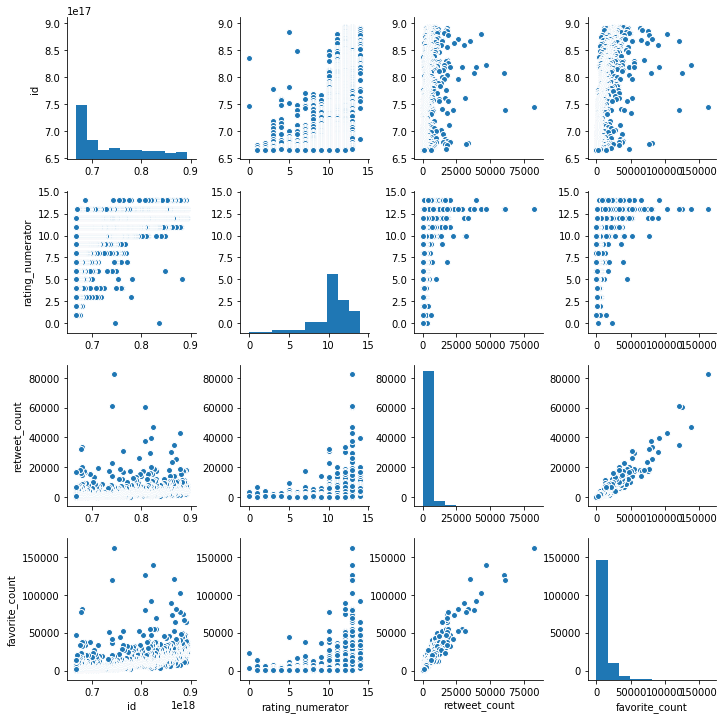

In [157]:
# scatterplot matrix to visually inspect data
sns.pairplot(df1);

In [158]:
#create correlation matrix
twitter_archive_master.corr()

,id,rating_numerator,retweet_count,favorite_count,year,month,week,day
id,1.000000,0.522548,0.383736,0.611695,0.882332,-0.310387,-0.331859,-0.013946
rating_numerator,0.522548,1.000000,0.286957,0.381002,0.489907,-0.218287,-0.228755,0.012785
retweet_count,0.383736,0.286957,1.000000,0.929493,0.330624,-0.100276,-0.107225,0.006626
favorite_count,0.611695,0.381002,0.929493,1.000000,0.529412,-0.167390,-0.177321,-0.000192
year,0.882332,0.489907,0.330624,0.529412,1.000000,-0.720005,-0.718230,-0.006607
month,-0.310387,-0.218287,-0.100276,-0.167390,-0.720005,1.000000,0.962352,-0.010805
week,-0.331859,-0.228755,-0.107225,-0.177321,-0.718230,0.962352,1.000000,0.008819
day,-0.013946,0.012785,0.006626,-0.000192,-0.006607,-0.010805,0.008819,1.000000


In [3]:
# group rating_numerator means
df_time =twitter_archive_master.groupby(['year', 'month'])['rating_numerator'].mean().reset_index()

In [160]:
# inspect data
df_time

,year,month,rating_numerator
0,2015,11,8.884746
1,2015,12,9.608815
2,2016,1,10.095808
3,2016,2,10.110092
4,2016,3,10.410256
5,2016,4,10.415094
6,2016,5,10.875000
7,2016,6,10.123457
8,2016,7,10.800000
9,2016,8,10.932203


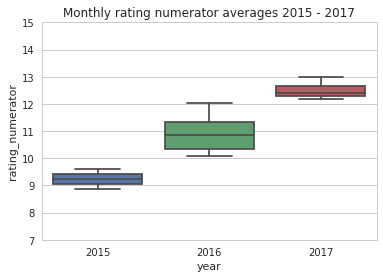

In [4]:
# boxplots of monthly rating_numerator distributions 
sns.set(style='whitegrid')
ax = sns.boxplot(x='year', y='rating_numerator', data=df_time)
ax.set_title('Monthly rating numerator averages 2015 - 2017')
ax.set_ylim(7,15);


**EDA Summary**

**There are 1971 entries between 2015-11-15 and 2017-08-01 in my master data frame. The 4 favourite names with equally 10 counts are Cooper, Lucy, Oliver, Charlie. Only one female name out of 4. Within the top 10 there are 40% female names. The preferred dog breeds for sending tweets are Golden Retriever, Labrador Retriever, Pembroke, Chihuahua in this order. Higher rating numerators are associated with higher favorite counts or vice versa. The same holds true for retweet counts. The correlation between these variables are rather low. There is also a clear positive correlation between retweet counts and favorite counts. The correlation coefficient of 0.929 is very high. The rating numerator increased over time and is highest in 2017. As the boxplots are not overlapping the increase per year in the average rating is significantly different between years. I assume that dogs did not get cuter each year therefore I would conclude that there is a time bias in the rating numerator data which has to be taken into account in the analysis section. The rating_numerator is left skewed with a median of 11 and a mean of 10.54. The average favorite count is 8635 and the average retweet count is 2617.**

# Analysis

### Which dog breed gets the highest ratings?

**Define**

**As the data have a time bias I will only take breeds with  more than 9 observations into account. Otherwise the highest ratings would be with dog breeds with single observations in 2017**

In [162]:
# distribution of number of observations per breed
twitter_archive_master['breed'].value_counts()

udo                               305
golden retriever                  155
labrador retriever                103
pembroke                           95
chihuahua                          91
pug                                62
toy poodle                         51
chow                               47
pomeranian                         41
samoyed                            41
malamute                           33
chesapeake bay retriever           31
french bulldog                     30
cocker spaniel                     30
miniature pinscher                 25
eskimo dog                         22
cardigan                           21
german shepherd                    21
staffordshire bullterrier          21
shih tzu                           20
beagle                             20
rottweiler                         19
siberian husky                     19
maltese dog                        19
shetland sheepdog                  19
lakeland terrier                   18
italian grey

In [163]:
# groupby breed and calculate mean rating_numerator
df_breed_rat_avg = twitter_archive_master.groupby('breed')['rating_numerator'].mean()


In [164]:
# select breeds with > 9 observations
df_breed_rat_avg = df_breed_rat_avg[twitter_archive_master['breed'].value_counts() > 9].sort_values(ascending=False).reset_index()

In [165]:
# inspect data
df_breed_rat_avg[:5]

,breed,rating_numerator
0,samoyed,11.731707
1,golden retriever,11.535484
2,great pyrenees,11.428571
3,pembroke,11.410526
4,eskimo dog,11.409091


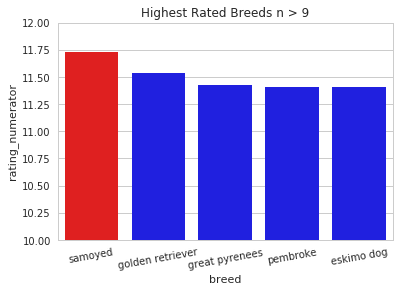

In [166]:
# print highest rated breeds
sns.set(style='whitegrid')
values = np.array([11.732, 11.535, 11.429, 11.411, 11.410])
clr = ['blue' if (x < max(values)) else 'red' for x in values]
ax = sns.barplot(x='breed', y='rating_numerator', data=df_breed_rat_avg[:5], palette=clr)
ax.set_ylim(10,12)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
ax.set_title('Highest Rated Breeds n > 9');

**Summary**

**Samoyed is the highest rated dog breed, followed by Golden Retriever. Golden retriever I would have expected because this is one of the classic dogs everybody likes. I am quite surprised as a non doggoholic that there seems to be a preference for not so well known breeds from the twitter rater.**

### Which dog breed gets the highest favorite counts ?

**Define**

**To make the data comparable with ratings only dog breeds with more than 9 observations will be taken into account. Therefore no need to check for time bias.**

In [167]:
# groupby breed and calculate mean favorite_count
df_breed_fav_avg = twitter_archive_master.groupby('breed')['favorite_count'].mean()

In [168]:
# select breeds with > 9 observations
df_breed_fav_avg = df_breed_fav_avg[twitter_archive_master['breed'].value_counts() > 9].sort_values(ascending=False).reset_index()

In [169]:
# inspect data
df_breed_fav_avg[:5]

,breed,favorite_count
0,french bulldog,19432.033333
1,whippet,13974.000000
2,english springer,13467.100000
3,standard poodle,13257.818182
4,cocker spaniel,13127.566667


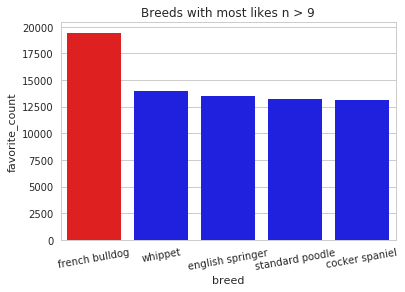

In [170]:
# print breeds with highest favorite count
sns.set(style='whitegrid')
values = np.array([19432, 13974, 13467, 13257, 13127])
clr = ['blue' if (x < max(values)) else 'red' for x in values]
ax = sns.barplot(x='breed', y='favorite_count', data=df_breed_fav_avg[:5], palette=clr)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
ax.set_title('Breeds with most likes n > 9');

**Summary**

**In contrast to the twitter raters the public votes more for well known dog breeds like poodle, spaniel, bulldog. The public voting is different than the twitter rating at least for the most favored breeds. Therefore we could make a new rating variable which consists of both public votes and twitter ratings. Although for this project I will not go this way.**

### Which dog stage gets the highest ratings?


**Define**

**Explore the mean of the highest ratings for the twitter dog stages from twitter raters**

In [171]:
# calculate average ratings for dog stages
df_stages_rat_avg = twitter_archive_master.groupby('stages')['rating_numerator'].mean().reset_index()

In [172]:
# sort values
df_stages_rat_avg = df_stages_rat_avg.sort_values(by='rating_numerator', ascending=False)

In [173]:
# inspect data
df_stages_rat_avg

,stages,rating_numerator
3,puppo,12.111111
0,doggo,11.761905
1,floofer,11.676471
2,pupper,10.582569
4,usd,10.414179


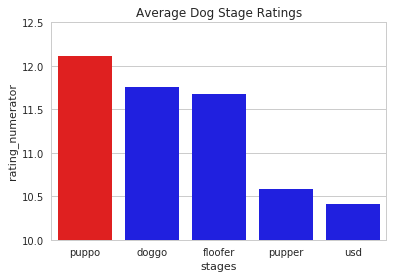

In [174]:
# print dog stage rating
sns.set(style='whitegrid')
values = np.array([12, 11.7, 11.6, 10.6, 10.4])
clr = ['blue' if (x < max(values)) else 'red' for x in values]
ax = sns.barplot(x='stages', y='rating_numerator', data=df_stages_rat_avg, palette=clr )
ax.set_ylim(10,12.5)
ax.set_title('Average Dog Stage Ratings');


In [5]:
# create a time series for dog stage ratings
df_stages =twitter_archive_master.groupby(['stages', 'year', 'month'])['rating_numerator'].mean().reset_index()

In [176]:
# inspect data
df_stages

,stages,year,month,rating_numerator
0,doggo,2015,12,9.000000
1,doggo,2016,4,10.666667
2,doggo,2016,5,11.000000
3,doggo,2016,6,12.000000
4,doggo,2016,7,10.571429
5,doggo,2016,8,10.666667
6,doggo,2016,9,11.000000
7,doggo,2016,10,11.800000
8,doggo,2016,11,12.000000
9,doggo,2016,12,11.200000


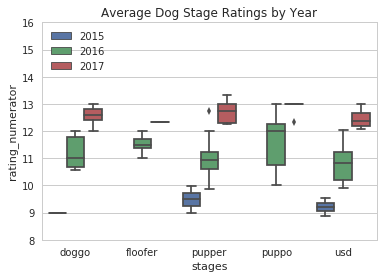

In [177]:
# print time series of dog stage ratings
sns.set(style='whitegrid')
ax = sns.boxplot(x='stages', y='rating_numerator', hue='year', data=df_stages)
ax.set_ylim(8,16)
ax.legend(loc='upper left')
ax.set_title('Average Dog Stage Ratings by Year');


**Summary**

**On average over the years puppos got the highest ratings from twitter. This would be expected as dogs are cutest in their puppy stage. Here at WeRateDogs this could also be a result of the fact that puppos do not have ratings in 2015 where ratings were lowest. Doggos who are rated second are beaten by puppers in 2017 and floofers in 2016 but puppers have a lot of 2015 ratings and floofers not enough ratings in 2017. Dogs that have no stage rating are constantly rated lowest. A stage rating seems to be already a quality feature.** 

### Which dog stage gets the highest favorite counts?

**Define**

**Explore which of the Twitter dog stages gets the highest mean numbwr of likes**

In [6]:
# calculate average favorite counts for dog stages
df_stages_fav_avg = twitter_archive_master.groupby('stages')['favorite_count'].mean().reset_index()

In [7]:
# sort values
df_stages_fav_avg = df_stages_fav_avg.sort_values(by='favorite_count', ascending=False)

In [180]:
# inspect data
df_stages_fav_avg

,stages,favorite_count
3,puppo,21722.703704
0,doggo,18482.285714
1,floofer,8413.441176
4,usd,8137.963308
2,pupper,6920.729358


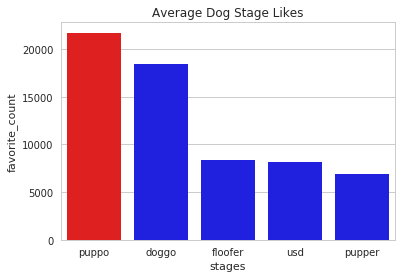

In [8]:
# print dog stage favorite count
sns.set(style='whitegrid')
values = np.array([21722, 18482, 8413, 8137, 6920])
clr = ['blue' if (x < max(values)) else 'red' for x in values]
ax = sns.barplot(x='stages', y='favorite_count', data=df_stages_fav_avg, palette=clr )
ax.set_title('Average Dog Stage Likes');

In [182]:
# create a time series for dog stage favorite count
df_stages1 =twitter_archive_master.groupby(['stages', 'year', 'month'])['favorite_count'].mean().reset_index()

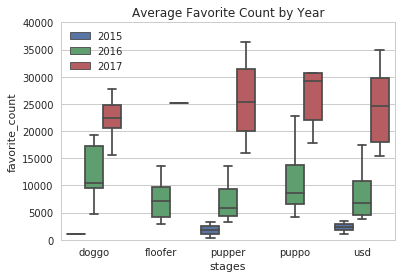

In [183]:
# print time series of dog stage favorite count
sns.set(style='whitegrid')
ax = sns.boxplot(x='stages', y='favorite_count', hue='year', data=df_stages1)
ax.legend(loc='upper left')
ax.set_ylim(0, 40000)
ax.set_title('Average Favorite Count by Year');

**Summary**

**Regarding the variable dog stage the public opinion and the twitter raters are conform. The puppo stage is the most favored. Also with this variable we can observe that it increased over time significantly. Puppos again do not have 2015 votes therefore they have an advantage over the other stages. Puppers seem to have gained popularity in 2017 because they got the most likes. This is in sharp contrast to the overall rating where puppers take the last place.**

### Is a prediction of the year of the tweet possible?

**Define**

**Is it possible to predict the year from favorite counts from followers and ratings from Twitter?**

In [54]:
# twitter archive master is ordered therefore randomize tarin and test set
train_data = twitter_archive_master.sample(1971, replace=True)

In [55]:
# inspect data
train_data

,id,names,stages,source,Timestamp,rating_numerator,retweet_count,favorite_count,breed,year,month,week,day,intercept
1759,670040295598354432,Not a name,usd,http://twitter.com/download/iphone,2015-11-27 00:43:49,10,113,755,borzoi,2015,11,48,4,1
1475,675820929667219457,Not a name,pupper,http://twitter.com/download/iphone,2015-12-12 23:34:00,11,239,1072,basset,2015,12,50,5,1
1115,697270446429966336,Bentley,usd,http://twitter.com/download/iphone,2016-02-10 04:06:43,10,1963,4846,toy poodle,2016,2,6,2,1
482,789986466051088384,Happy,usd,http://twitter.com/download/iphone,2016-10-23 00:27:05,12,2505,9790,golden retriever,2016,10,42,6,1
1036,704480331685040129,Lucia,floofer,http://twitter.com/download/iphone,2016-03-01 01:36:14,11,1108,3520,samoyed,2016,3,9,1,1
532,780601303617732608,Hercules,usd,http://twitter.com/download/iphone,2016-09-27 02:53:48,12,3597,12751,saint bernard,2016,9,39,1,1
1346,680940246314430465,Alice,usd,http://twitter.com/download/iphone,2015-12-27 02:36:20,4,1113,3331,soft coated wheaten terrier,2015,12,52,6,1
814,737310737551491075,Not a name,pupper,http://twitter.com/download/iphone,2016-05-30 15:52:33,13,7814,15192,udo,2016,5,22,0,1
1776,669597912108789760,Skye,usd,http://twitter.com/download/iphone,2015-11-25 19:25:57,10,152,514,eskimo dog,2015,11,48,2,1
731,748568946752774144,Cora,usd,http://twitter.com/download/iphone,2016-06-30 17:28:39,12,710,2276,tibetan terrier,2016,6,26,3,1


In [56]:
# create train data set
train_data_train = train_data.iloc[:1500, 5:8]

In [60]:
# clean train data set
train_data_train.drop('retweet_count', axis=1, inplace=True)

In [61]:
# inspect train data set
train_data_train.head(1)

,rating_numerator,favorite_count
1759,10,755


In [62]:
# create test data set
train_data_test = train_data.iloc[1500:, 5:8]

In [63]:
# clean test data set
train_data_test.drop('retweet_count', axis=1, inplace=True)

In [64]:
# create train targets
test_data_train = train_data.iloc[:1500, 9:10]

In [66]:
# create test targets
test_data_test = train_data.iloc[1500:,9:10]

In [111]:
# create logistic regression model
log_reg = LogisticRegression(random_state=0, multi_class='ovr' )
# fit model
model = log_reg.fit(train_data_train, test_data_train)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [108]:
# create data frame for test data
df_model = pd.concat([train_data_test, test_data_test], axis=1)

In [112]:
# add predictions to test data data frame
df_model['predicted'] = model.predict(train_data_test)

In [88]:
# inspect data frame
df_model.head(1)

,rating_numerator,favorite_count,year,predicted
776,10,4587,2016,2016


In [113]:
# calculate accuracy for predictions
(df_model['year'] == df_model['predicted']).mean()

0.73036093418259018

**Summary**

**It is possible to predict the year trough the amount of likes from users and Twitter ratings. The accuracy of the predictions is rather low with 73%. Here I do think that we can do better but this is another project.**

### Are higher ratings associated with certain dog names??

**Define**

**Is there a tendency for certain names in the 5 highest rated dog breeds?**

In [190]:
# extract highest rated dog breeds
df_y = twitter_archive_master[twitter_archive_master['breed'].str.contains('golden retriever'or 'samoyed'or 'great pyrenees'or 'pembroke' or 'eskimo dog')]




In [191]:
# analyze dog names
df_y['names'].value_counts()[:10]

Not a name    49
Lucy           4
Peaches        2
Zeke           2
Moe            2
Winnie         2
Bella          2
Zeus           2
Eleanor        1
Eve            1
Name: names, dtype: int64

**Summary**

**A tendency towards a single name is not given. Interesting to notice though is the amount of female names within the top 5 rated breeds. 70 % of the top 10 dog names for the highest rated breeds are female names whereas as seen in the EDA section only 40% out of the top 10 names are female names. This could be explored in more depth in another project.**

### What is the distribution of original tweets for certain weekdays?


In [3]:
# count the number of tweets per weekday
df_activity = twitter_archive_master['day'].value_counts().reset_index()

In [193]:
# inspect data
df_activity

,index,day
0,0,324
1,2,295
2,1,292
3,3,280
4,4,278
5,5,252
6,6,250


In [4]:
# value cast to string
df_activity['index'] = df_activity['index'].apply(str)

In [5]:
# introduce weekday names
df_activity['weekday'] = ['Monday' if '0' in text
                         else 'Tuesday' if '1' in text
                         else 'Wednesday' if '2' in text
                         else 'Thursday' if '3' in text
                         else 'Friday' if '4' in text
                         else 'Saturday' if '5' in text
                         else 'Sunday' for text in df_activity['index']]

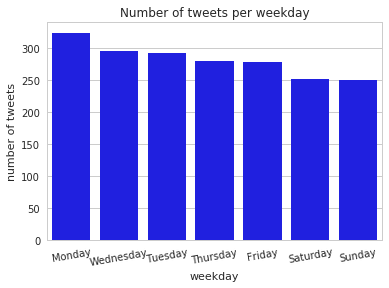

In [7]:
# plot data
sns.set(style='whitegrid')
ax = sns.barplot(x='weekday', y='day', data=df_activity, color = 'b')
ax.legend(loc='upper left')
ax.set_title('Number of tweets per weekday')
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)
ax.set_ylabel('number of tweets');


**Summary**

**It is interesting to see that the magnitude of the tweet frequency nearly exactly correlates with weekdays starting with highest number on Monday and ending with lowest numbers on weekends.**

### Are retweet and favorite counts correlated?

**As already seen in the EDA retweet counts and favorite counts are highly correlated with a correlation coefficient of approximately 0.93.**